In [ ]:
pip install langchain-gigachat langchain-chroma langchain-core pandas numpy openai

In [98]:
import pandas as pd
import numpy as np
from openai import OpenAI
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_gigachat.embeddings.gigachat import GigaChatEmbeddings
from langchain_gigachat.chat_models import GigaChat
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
import ast
import matplotlib.pyplot as plt
import time

In [2]:
# Функция загрузки датасета
def load_embeddings_to_dataframe(filepath):
    """
    Загружает данные эмбеддингов из CSV файла в pandas DataFrame
    
    Args:
        filepath (str): Путь к файлу с данными
        
    Returns:
        pd.DataFrame: DataFrame с загруженными данными
    """
    try:
        df = pd.read_csv(filepath)
        print(f"Загружено {len(df)} записей из файла {filepath}")
        print(f"Колонки: {df.columns.tolist()}")
        print(f"\nПервые 3 записи:")
        print(df.head(3))
        return df
    except Exception as e:
        print(f"Произошла ошибка при загрузке данных: {e}")
        return None

# Загрузка данных
df = load_embeddings_to_dataframe("arxiv_embeddings202505211515.csv")

Загружено 50000 записей из файла arxiv_embeddings202505211515.csv
Колонки: ['article_id', 'submitter', 'authors', 'title', 'comments', 'journal_ref', 'doi', 'report_no', 'categories', 'main_category', 'other_categories', 'license', 'abstract', 'versions', 'authors_parsed', 'year', 'embedding_bge_m3']

Первые 3 записи:
     article_id submitter                                            authors  \
0  2410.08001v2       NaN  {"Qingwen Bu","Hongyang Li","Li Chen","Jisong ...   
1  2410.11878v1       NaN                     {"Xingyi Yang","Xinchao Wang"}   
2  2410.07991v3       NaN  {"Tommaso Giorgi","Lorenzo Cima","Tiziano Fagn...   

                                               title comments journal_ref  \
0  Towards Synergistic, Generalized, and Efficien...      NaN         NaN   
1                               Neural Metamorphosis      NaN         NaN   
2  Human and LLM Biases in Hate Speech Annotation...      NaN         NaN   

   doi report_no           categories main_categor

In [3]:
# Просмотр информации о датасете
print(f"Размер датасета: {df.shape}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПроверка пропущенных значений:\n{df.isnull().sum()}")

Размер датасета: (50000, 17)

Типы данных:
article_id          object
submitter           object
authors             object
title               object
comments            object
journal_ref         object
doi                 object
report_no           object
categories          object
main_category       object
other_categories    object
license             object
abstract            object
versions            object
authors_parsed      object
year                 int64
embedding_bge_m3    object
dtype: object

Проверка пропущенных значений:
article_id              0
submitter            9197
authors                 0
title                   0
comments            23907
journal_ref         43700
doi                 43125
report_no           47991
categories              0
main_category           0
other_categories     6907
license              9363
abstract                0
versions             9197
authors_parsed       9197
year                    0
embedding_bge_m3        0
dtype: int

In [57]:
def raw_list_to_normal(x: str) -> list[str]:
    if type(x) != str:
        return []
    x = x.replace('{', '').replace('}', '')
    # return x.split(',')
    x = x.split(' ')
    x1 = [x[0]]
    for i in x[1:]:
        if i.count('.') == 0:
            x1[-1] += ' ' + i
        else:
            x1.append(i)
    return x1

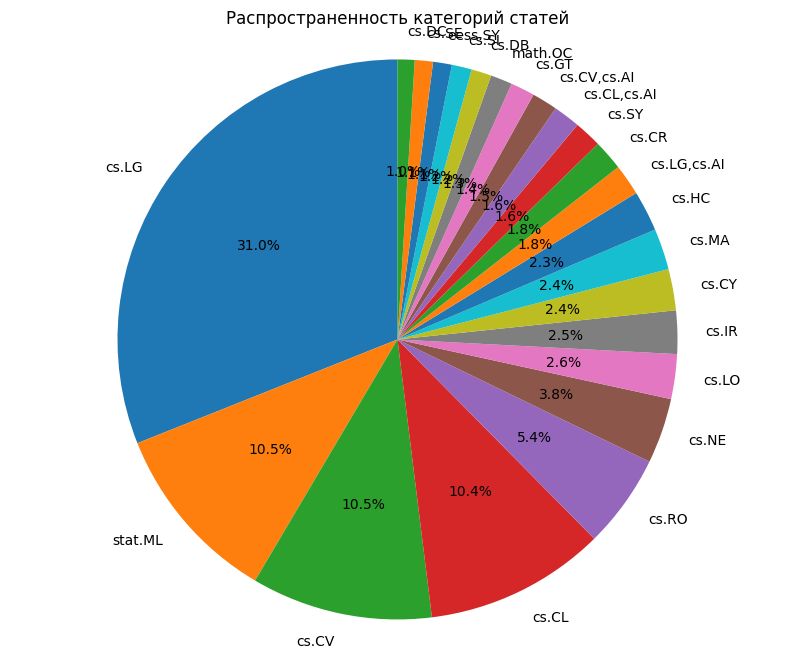

In [76]:
# Статистика по категориям статей (столбец categories)
df_categories = df['categories'].map(raw_list_to_normal)

all_categories = [i for j in df_categories for i in j if i != 'cs.AI']
category_counts = pd.Series(all_categories).value_counts()

category_counts = category_counts[category_counts >= 500]

plt.figure(figsize=(10, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распространенность категорий статей')
plt.axis('equal')
plt.show()

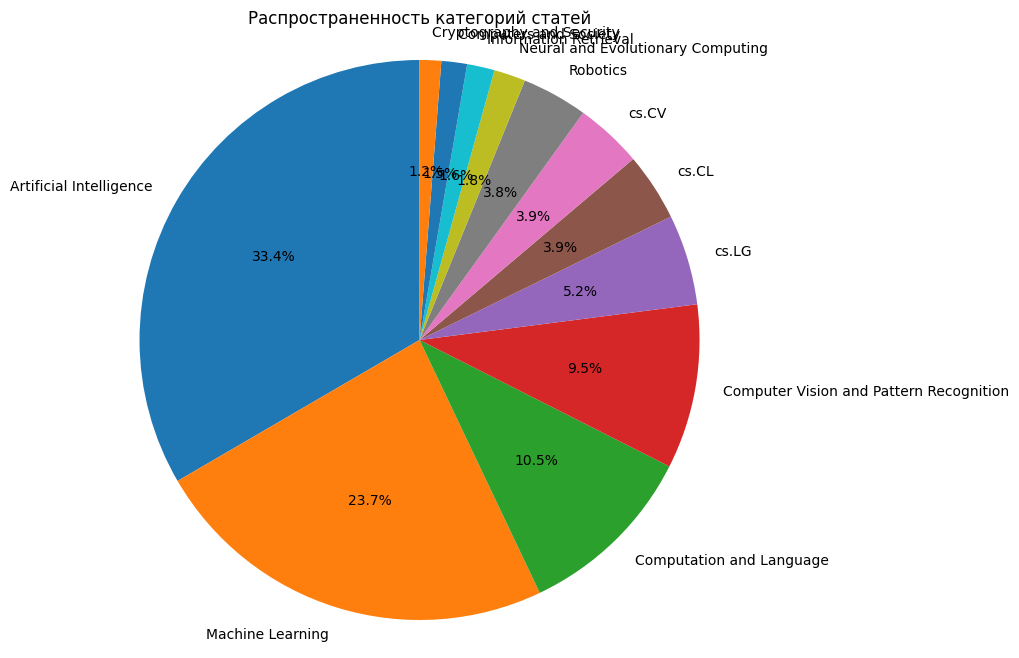

In [69]:
# Статистика по категориям статей (столбец main_category)
df_main_category = df['main_category'].map(raw_list_to_normal)

all_categories = [i for j in df_main_category for i in j if i != 'cs.AI']
category_counts = pd.Series(all_categories).value_counts()

category_counts = category_counts[category_counts >= 500]

plt.figure(figsize=(10, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распространенность категорий статей')
plt.axis('equal')
plt.show()

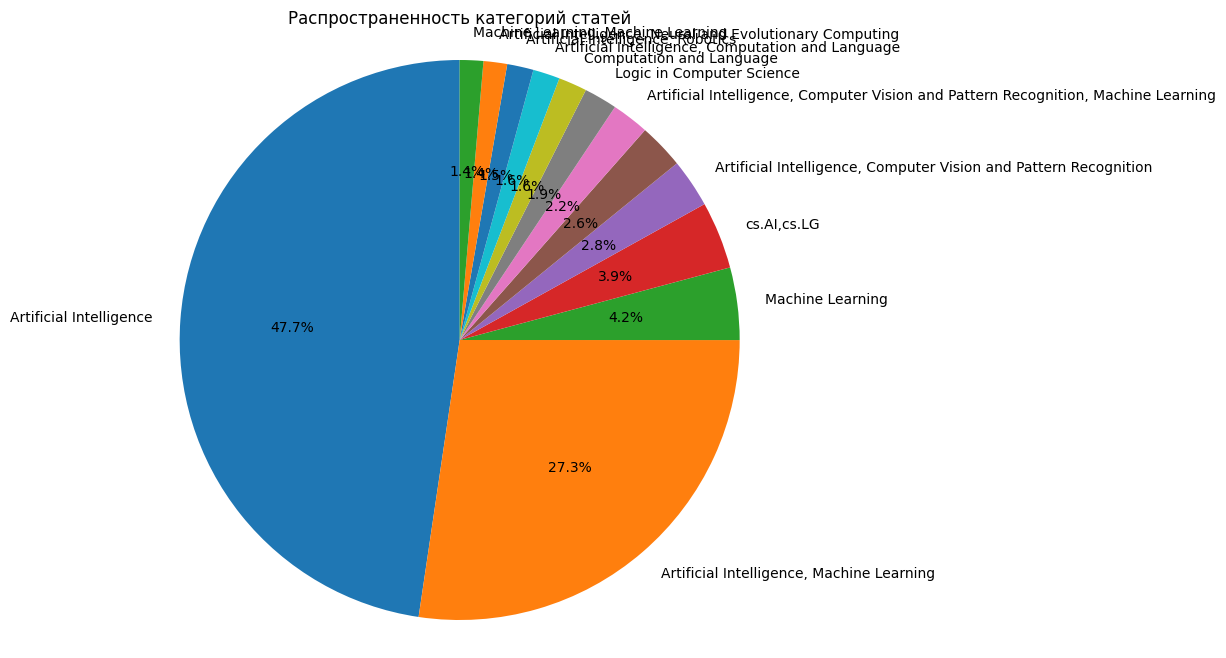

In [71]:
# Статистика по категориям статей (столбец other_categories)
df_other_categories = df['other_categories'].map(raw_list_to_normal)

all_categories = [i for j in df_other_categories for i in j if i != 'cs.AI']
category_counts = pd.Series(all_categories).value_counts()

category_counts = category_counts[category_counts >= 300]

plt.figure(figsize=(10, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распространенность категорий статей')
plt.axis('equal')
plt.show()

In [77]:
def select_random_rows(df: pd.DataFrame, n=1000, random_state=123) -> pd.DataFrame:
    """
    Выбирает n случайных строк из датафрейма
    """
    
    # Выбираем случайные строки
    random_rows = df.sample(n=n, random_state=random_state)
    
    return random_rows

df = select_random_rows(df)

In [79]:
def prepare_documents(df, limit=1000):
    """
    Преобразует DataFrame в список документов LangChain
    
    Args:
        df: DataFrame с данными статей
        limit: Количество документов для обработки
        
    Returns:
        List[Document]: Список документов
    """
    documents = []
    
    # Возьмите первые limit записей
    df_subset = df.head(limit)
    
    for idx, row in df_subset.iterrows():
        # Формируйте текст документа из доступных полей
        page_content = ''
        
        # Адаптируйте под структуру вашего датасета
        if 'title' in row:
            page_content += f"Название: {row['title']}\n"
        if 'abstract' in row:
            page_content += f"Аннотация: {row['abstract']}\n"
        if 'authors' in row:
            page_content += f"Авторы: {row['authors']}\n"
        
        # Метаданные
        metadata = {}
        if 'category' in row:
            metadata['category'] = row['category']
        if 'date' in row:
            metadata['date'] = row['date']
        if 'arxiv_id' in row:
            metadata['arxiv_id'] = row['arxiv_id']
        
        documents.append(Document(
            page_content=page_content,
            metadata=metadata
        ))
    
    print(f"Подготовлено {len(documents)} документов")
    return documents

# Подготовка документов
documents = prepare_documents(df, limit=1000)

# Просмотр примера документа
print("Пример документа:")
print(f"Содержимое: {documents[0].page_content[:200]}...")
print(f"Метаданные: {documents[0].metadata}")

Подготовлено 1000 документов
Пример документа:
Содержимое: Название: Planning in POMDPs Using Multiplicity Automata
Аннотация:   Planning and learning in Partially Observable MDPs (POMDPs) are among the
most challenging tasks in both the AI and Operation Rese...
Метаданные: {}


In [80]:
# Конфигурация OpenAI клиента для получения эмбеддингов
client = OpenAI(     
    api_key="ZmJhMjUwZTItMDg0ZC00N2E3LWIyNDktYjA4MTQyZGFmMGE4.97f6d089a16317c3aa93b365eda739a8",
    base_url="https://foundation-models.api.cloud.ru/v1"
)


def get_embedding(text: str, model="BAAI/bge-m3") -> list:
    """Получает эмбеддинг текста"""
    response = client.embeddings.create(
        input=[text],
        model=model
    )
    return response.data[0].embedding

# Тестирование функции эмбеддингов
test_embedding = get_embedding("Тестовый запрос")
print(f"Размерность эмбеддинга: {len(test_embedding)}")

Размерность эмбеддинга: 1024


In [81]:
from langchain_core.embeddings import Embeddings
from typing import List

class CustomEmbeddings(Embeddings):
    """Кастомный класс эмбеддингов для работы с API"""
    
    def __init__(self, client, model="BAAI/bge-m3"):
        self.client = client
        self.model = model
    
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Получение эмбеддингов для списка документов"""
        embeddings = []
        for text in texts:
            response = self.client.embeddings.create(
                input=[text],
                model=self.model
            )
            embeddings.append(response.data[0].embedding)
        return embeddings
    
    def embed_query(self, text: str) -> List[float]:
        """Получение эмбеддинга для запроса"""
        response = self.client.embeddings.create(
            input=[text],
            model=self.model
        )
        return response.data[0].embedding

# Создание экземпляра эмбеддингов
embeddings = CustomEmbeddings(client)

In [82]:
# Создание векторного хранилища ChromaDB
print("Создание векторного хранилища...")
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    collection_name="arxiv_papers",
    persist_directory="./chroma_db"  # Директория для сохранения
)
print("Векторное хранилище успешно создано!")

# Проверка работы хранилища
test_query = "машинное обучение и нейронные сети"
results = vectorstore.similarity_search(test_query, k=3)
print(f"\nРезультаты поиска по запросу '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"\n{i}. {doc.page_content[:200]}...")
    print(f"   Метаданные: {doc.metadata}")

Создание векторного хранилища...
Векторное хранилище успешно создано!

Результаты поиска по запросу 'машинное обучение и нейронные сети':

1. Название: Recognition Networks for Approximate Inference in BN20 Networks
Аннотация:   We propose using recognition networks for approximate inference inBayesian
networks (BNs). A recognition network ...
   Метаданные: {}

2. Название: Distributionally Robust Multilingual Machine Translation
Аннотация:   Multilingual neural machine translation (MNMT) learns to translate multiple
language pairs with a single model, potentia...
   Метаданные: {}

3. Название: QMDP-Net: Deep Learning for Planning under Partial Observability
Аннотация:   This paper introduces the QMDP-net, a neural network architecture for
planning under partial observability. The ...
   Метаданные: {}


In [83]:
# Разные значения k
test_query = "машинное обучение и нейронные сети"
results2 = vectorstore.similarity_search(test_query, k=2)
print(f"\nРезультаты поиска по запросу '{test_query}':")
for i, doc in enumerate(results2, 1):
    print(f"\n{i}. {doc.page_content[:200]}...")
    print(f"   Метаданные: {doc.metadata}")
    
results5 = vectorstore.similarity_search(test_query, k=5)
print(f"\nРезультаты поиска по запросу '{test_query}':")
for i, doc in enumerate(results5, 1):
    print(f"\n{i}. {doc.page_content[:200]}...")
    print(f"   Метаданные: {doc.metadata}")


Результаты поиска по запросу 'машинное обучение и нейронные сети':

1. Название: Recognition Networks for Approximate Inference in BN20 Networks
Аннотация:   We propose using recognition networks for approximate inference inBayesian
networks (BNs). A recognition network ...
   Метаданные: {}

2. Название: Distributionally Robust Multilingual Machine Translation
Аннотация:   Multilingual neural machine translation (MNMT) learns to translate multiple
language pairs with a single model, potentia...
   Метаданные: {}

Результаты поиска по запросу 'машинное обучение и нейронные сети':

1. Название: Recognition Networks for Approximate Inference in BN20 Networks
Аннотация:   We propose using recognition networks for approximate inference inBayesian
networks (BNs). A recognition network ...
   Метаданные: {}

2. Название: Distributionally Robust Multilingual Machine Translation
Аннотация:   Multilingual neural machine translation (MNMT) learns to translate multiple
language pairs with a sing

In [84]:
# Поиск по нескольким запросам
test_queries = ["машинное обучение и нейронные сети", "Анализ данных"]
results = []
for test_query in test_queries:
    results.append(vectorstore.similarity_search(test_query, k=3))
for i in range(len(test_queries)):
    print(f"\nРезультаты поиска по запросу '{test_queries[i]}':")
    for j, doc in enumerate(results[i], 1):
        print(f"\n{j}. {doc.page_content[:200]}...")
        print(f"   Метаданные: {doc.metadata}")


Результаты поиска по запросу 'машинное обучение и нейронные сети':

1. Название: Recognition Networks for Approximate Inference in BN20 Networks
Аннотация:   We propose using recognition networks for approximate inference inBayesian
networks (BNs). A recognition network ...
   Метаданные: {}

2. Название: Distributionally Robust Multilingual Machine Translation
Аннотация:   Multilingual neural machine translation (MNMT) learns to translate multiple
language pairs with a single model, potentia...
   Метаданные: {}

3. Название: QMDP-Net: Deep Learning for Planning under Partial Observability
Аннотация:   This paper introduces the QMDP-net, a neural network architecture for
planning under partial observability. The ...
   Метаданные: {}

Результаты поиска по запросу 'Анализ данных':

1. Название: Large-scale Analysis of Chess Games with Chess Engines: A Preliminary
  Report
Аннотация:   The strength of chess engines together with the availability of numerous
chess games have attracte...

In [91]:
# Использование метода similarity_search_with_score()
test_query = "машинное обучение и нейронные сети"
results = vectorstore.similarity_search_with_score(test_query, k=3)
print(f"\nРезультаты поиска по запросу '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"\n{i}. {doc[0].page_content[:200]}...")
    print(f"   Метаданные: {doc[0].metadata}")
    print(f"   Оценка схожести: {doc[1]}")


Результаты поиска по запросу 'машинное обучение и нейронные сети':

1. Название: Recognition Networks for Approximate Inference in BN20 Networks
Аннотация:   We propose using recognition networks for approximate inference inBayesian
networks (BNs). A recognition network ...
   Метаданные: {}
   Оценка схожести: 0.9003628492355347

2. Название: Distributionally Robust Multilingual Machine Translation
Аннотация:   Multilingual neural machine translation (MNMT) learns to translate multiple
language pairs with a single model, potentia...
   Метаданные: {}
   Оценка схожести: 0.9106622934341431

3. Название: QMDP-Net: Deep Learning for Planning under Partial Observability
Аннотация:   This paper introduces the QMDP-net, a neural network architecture for
planning under partial observability. The ...
   Метаданные: {}
   Оценка схожести: 0.9180231690406799


In [92]:
# Создание ретривера с поиском по схожести
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}  # Возвращать топ-5 документов
)

# Тестирование ретривера
query = "глубокое обучение для обработки изображений"
retrieved_docs = retriever.invoke(query)

print(f"Найдено документов: {len(retrieved_docs)}")
for i, doc in enumerate(retrieved_docs, 1):
    print(f"\nДокумент {i}:")
    print(doc.page_content[:150] + "...")

Найдено документов: 5

Документ 1:
Название: Deep learning for pedestrians: backpropagation in CNNs
Аннотация:   The goal of this document is to provide a pedagogical introduction to th...

Документ 2:
Название: Progressive Semantic Segmentation
Аннотация:   The objective of this work is to segment high-resolution images without
overloading GPU memor...

Документ 3:
Название: Interactive Classification for Deep Learning Interpretation
Аннотация:   We present an interactive system enabling users to manipulate image...

Документ 4:
Название: Empowering Backbone Models for Visual Text Generation with Input Granularity Control and Glyph-Aware Training
Аннотация: Diffusion-based tex...

Документ 5:
Название: Deep Loopy Neural Network Model for Graph Structured Data Representation
  Learning
Аннотация:   Existing deep learning models may encounter...


In [93]:
# MMR балансирует между релевантностью и разнообразием результатов
retriever_mmr = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 5,
        "fetch_k": 20,  # Количество документов для первичной выборки
        "lambda_mult": 0.5  # Баланс между релевантностью (1.0) и разнообразием (0.0)
    }
)

# Сравнение результатов
query = "обработка естественного языка"
docs_similarity = retriever.invoke(query)
docs_mmr = retriever_mmr.invoke(query)

print("Сравнение результатов поиска:")
print("\n=== Similarity Search ===")
for i, doc in enumerate(docs_similarity[:3], 1):
    print(f"{i}. {doc.page_content[:100]}...")

print("\n=== MMR Search ===")
for i, doc in enumerate(docs_mmr[:3], 1):
    print(f"{i}. {doc.page_content[:100]}...")

Сравнение результатов поиска:

=== Similarity Search ===
1. Название: Tibyan Corpus: Balanced and Comprehensive Error Coverage Corpus Using ChatGPT for Arabic G...
2. Название: Generative AI, Pragmatics, and Authenticity in Second Language Learning
Аннотация: There a...
3. Название: Reformulating Global Grammar Constraints
Аннотация:   An attractive mechanism to specify g...

=== MMR Search ===
1. Название: Tibyan Corpus: Balanced and Comprehensive Error Coverage Corpus Using ChatGPT for Arabic G...
2. Название: One to rule them all: natural language to bind communication, perception and action
Аннота...
3. Название: Developing Corpus-based Translation Methods between Informal and Formal
  Mathematics: Pro...


In [99]:
# Сравнение времени выполнения разных типов поиска
def retriever_ex_time(retr) -> int:
    query = "обработка естественного языка"
    start_time = time.time()
    retr.invoke(query)
    return time.time() - start_time

print("Сравнение времени выполнения:")
print("\n=== Similarity Search ===")
print(f"{retriever_ex_time(retriever)} мс")
print("\n=== MMR Search ===")
print(f"{retriever_ex_time(retriever_mmr)} мс")

Сравнение времени выполнения:

=== Similarity Search ===
0.6065459251403809 мс

=== MMR Search ===
0.3712024688720703 мс


In [96]:
# Эксперименты с lambda_mult
for i in [0, 0.5, 1]:
    retriever_mmr = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={
            "k": 5,
            "fetch_k": 20,  # Количество документов для первичной выборки
            "lambda_mult": i  # Баланс между релевантностью (1.0) и разнообразием (0.0)
        }
    )
    
    docs_mmr = retriever_mmr.invoke(query)
    print(f"\n=== {i} ===")
    for j, doc in enumerate(docs_mmr[:3], 1):
        print(f"{j}. {doc.page_content[:100]}...")



=== 0 ===
1. Название: Tibyan Corpus: Balanced and Comprehensive Error Coverage Corpus Using ChatGPT for Arabic G...
2. Название: A Methodology for Creating Question Answering Corpora Using Inverse Data
  Annotation
Анно...
3. Название: Active Learning for New Domains in Natural Language Understanding
Аннотация:   We explore ...

=== 0.5 ===
1. Название: Tibyan Corpus: Balanced and Comprehensive Error Coverage Corpus Using ChatGPT for Arabic G...
2. Название: One to rule them all: natural language to bind communication, perception and action
Аннота...
3. Название: Developing Corpus-based Translation Methods between Informal and Formal
  Mathematics: Pro...

=== 1 ===
1. Название: Tibyan Corpus: Balanced and Comprehensive Error Coverage Corpus Using ChatGPT for Arabic G...
2. Название: Generative AI, Pragmatics, and Authenticity in Second Language Learning
Аннотация: There a...
3. Название: Reformulating Global Grammar Constraints
Аннотация:   An attractive mechanism to specify g...


In [94]:
# Ретривер с фильтрацией по оценке схожести
retriever_threshold = vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "score_threshold": 0.7,  # Минимальная оценка схожести
        "k": 10
    }
)

# ВАЖНО: Не все векторные хранилища поддерживают score_threshold
# В случае ChromaDB может потребоваться другой подход

In [106]:
from decouple import config
llm = GigaChat(
    # credentials=config('AUTH_KEY_lab3'),
    credentials="YTViNDBiOGUtNzE2MS00MmQ1LWE5NmYtZjEzOWYwZjQzZjAxOmU3MTQzOGYxLTc4ZWMtNDFkZS05MzkzLWIxNDQ4NThmMThkOQ==",
    scope="GIGACHAT_API_B2B",
    model="Gigachat-2-Max",
    verify_ssl_certs=False,
    timeout=30
)

# Тест языковой модели
test_response = llm.invoke("Привет! Ответь кратко: что такое машинное обучение?")
print(f"Ответ модели: {test_response.content}")

Ответ модели: Машинное обучение — это область искусственного интеллекта, где алгоритмы самостоятельно обучаются выявлять закономерности и принимать решения на основе анализа данных без явного программирования человеком каждого шага.


In [107]:
# Шаблон промпта для RAG
prompt_template = """Ты -- научный ассистент, специализирующийся на анализе научных статей.
Твоя задача -- отвечать на вопросы пользователя, основываясь ТОЛЬКО на предоставленном контексте из научных статей ArXiv.

Правила:
1. Используй только информацию из контекста ниже
2. Если в контексте нет информации для ответа, честно скажи об этом
3. Указывай, из каких статей взята информация (если есть метаданные)
4. Отвечай на русском языке, четко и структурированно
5. Если вопрос касается технических деталей, будь точным

Контекст из научных статей:
{context}

Вопрос пользователя: {question}

Ответ:"""

prompt = ChatPromptTemplate.from_template(prompt_template)

In [108]:
def format_docs(docs):
    """
    Форматирует список документов в единую строку контекста
    
    Args:
        docs: Список документов Document
        
    Returns:
        str: Форматированный контекст
    """
    context_parts = []
    for i, doc in enumerate(docs, 1):
        context_parts.append(f"[Документ {i}]")
        context_parts.append(doc.page_content)
        if doc.metadata:
            context_parts.append(f"Метаданные: {doc.metadata}")
        context_parts.append("")  # Пустая строка для разделения
    return "\n".join(context_parts)

# Тест форматирования
test_docs = retriever.invoke("нейронные сети")
formatted_context = format_docs(test_docs[:2])
print("Пример форматированного контекста:")
print(formatted_context[:500] + "...")

Пример форматированного контекста:
[Документ 1]
Название: Learning Large-scale Network Embedding from Representative Subgraph
Аннотация:   We study the problem of large-scale network embedding, which aims to learn
low-dimensional latent representations for network mining applications. Recent
research in the field of network embedding has led to significant progress such
as DeepWalk, LINE, NetMF, NetSMF. However, the huge size of many real-world
networks makes it computationally expensive to learn network embedding from the
entire...


In [109]:
from langchain_core.runnables import RunnablePassthrough

# Создание RAG-цепочки
rag_chain = (
    {
        "context": retriever | format_docs,  # Извлекаем и форматируем документы
        "question": RunnablePassthrough()     # Передаем вопрос как есть
    }
    | prompt      # Формируем промпт
    | llm         # Отправляем в языковую модель
)

# Тестирование RAG-системы
questions = [
    "Какие методы машинного обучения используются для обработки изображений?",
    "Расскажи о применении трансформеров в обработке естественного языка",
    "Какие существуют подходы к обучению нейронных сетей?"
]

print("=== Тестирование RAG-системы ===\n")
for i, question in enumerate(questions, 1):
    print(f"Вопрос {i}: {question}")
    print("-" * 80)
    
    try:
        response = rag_chain.invoke(question)
        print(f"Ответ: {response.content}\n")
    except Exception as e:
        print(f"Ошибка: {e}\n")

=== Тестирование RAG-системы ===

Вопрос 1: Какие методы машинного обучения используются для обработки изображений?
--------------------------------------------------------------------------------
Ответ: На основе представленного контекста, в обработке изображений применяются следующие методы машинного обучения:

### [Документ 1]: **Interactive Classification**
- Метод основан на интерактивной классификации с использованием глубоких нейронных сетей (Deep Learning).
- Используется система для анализа чувствительности классификаторов изображений путем удаления элементов изображений через алгоритмы инпейнтинга и получения новых классификаций в режиме реального времени.

### [Документ 2]: **Exploiting Raw Images for Real-Scene Super-Resolution**
- Применяется метод улучшения разрешения изображений (Super Resolution):
  - Предлагается двухветвёвая сверточная нейронная сеть (Convolutional Neural Network — CNN) для извлечения визуальной информации из сырых снимков камер.
  - Введён плотный бл

In [ ]:
def interactive_rag_qa():
    """Интерактивная система вопросов-ответов"""
    print("=== Интерактивная RAG-система для научных статей ArXiv ===")
    print("Введите 'выход' для завершения\n")
    
    while True:
        question = input("Ваш вопрос: ").strip()
        
        if question.lower() in ['выход', 'exit', 'quit']:
            print("До свидания!")
            break
        
        if not question:
            continue
        
        try:
            # Получаем релевантные документы
            docs = retriever.invoke(question)
            print(f"\n📚 Найдено релевантных документов: {len(docs)}")
            
            # Генерируем ответ
            response = rag_chain.invoke(question)
            print(f"\n🤖 Ответ:\n{response.content}\n")
            
            # Показываем источники
            show_sources = input("Показать источники? (да/нет): ").strip().lower()
            if show_sources in ['да', 'yes', 'y', 'д']:
                print("\n📖 Источники:")
                for i, doc in enumerate(docs[:3], 1):
                    print(f"\n{i}. {doc.page_content[:200]}...")
                    print(f"   Метаданные: {doc.metadata}")
            
            print("\n" + "="*80 + "\n")
            
        except Exception as e:
            print(f"❌ Ошибка: {e}\n")

# Запуск интерактивной системы (раскомментируйте для использования)
# interactive_rag_qa()